<a href="https://colab.research.google.com/github/sudhakar-ai/starter-web/blob/master/Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sudhakar0","key":"4cfc63dc58ac36946320a3067fd23d79"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download mohamedmustafa/real-life-violence-situations-dataset

100% 3.57G/3.58G [00:40<00:00, 133MB/s]
100% 3.58G/3.58G [00:40<00:00, 95.0MB/s]


In [5]:
! unzip /content/real-life-violence-situations-dataset.zip

Archive:  /content/real-life-violence-situations-dataset.zip
  inflating: Real Life Violence Dataset/NonViolence/NV_1.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_10.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_100.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_1000.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_101.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_102.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_103.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_104.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_105.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_106.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_107.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_108.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_109.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_11.mp4  
  inflating: Real Life Violence 

In [6]:
%rm -rf '/content/real life violence situations'

In [7]:
DIR_PATH = '/content/Real Life Violence Dataset/'

In [8]:
import os
import collections
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

# Define constants
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3
NUM_FRAMES = 60
NUM_CLASSES = 2
LENGTH_OF_SUBSET = 50
BATCH_SIZE = 5
EPOCHS = 3

class VideoDatasetLoader:
    """
    Class to load and preprocess video datasets for classification tasks.
    """

    def __init__(self, input_dataset_path=DIR_PATH, classes=['Violence', 'Non_Violence']):
        """
        Initializes the VideoDatasetLoader class.

        Args:
            input_dataset_path (str): Path to the directory containing the dataset.
            classes (list): List of class names.
        """
        self.input_dataset_path = input_dataset_path
        self.classes = classes

    def get_files_for_classes(self):
        """
        Collects file paths for each class in the dataset directory.

        Returns:
            dict: Dictionary containing file paths for each class.
        """
        file_for_classes = collections.defaultdict(list)
        for dirpath, _, filenames in os.walk(self.input_dataset_path):
            for filename in filenames:
                if filename.startswith('V'):
                    file_for_classes[self.classes[0]].append(os.path.join(dirpath, filename))
                elif filename.startswith('NV'):
                    file_for_classes[self.classes[1]].append(os.path.join(dirpath, filename))
        return file_for_classes

    def split_dataset(self):
        """
        Splits the dataset into training, validation, and testing sets.

        Returns:
            tuple: A tuple containing file paths and labels for training, validation, and testing sets.
        """
        file_paths_dict = self.get_files_for_classes()
        all_file_paths = []
        all_labels = []

        for classes, file_paths in file_paths_dict.items():
            all_file_paths.extend(file_paths)
            all_labels.extend([classes] * len(file_paths))

        all_file_paths = all_file_paths[:LENGTH_OF_SUBSET]
        all_labels = all_labels[:LENGTH_OF_SUBSET]

        X_train, X_test_val, Y_train, Y_test_val = train_test_split(all_file_paths, all_labels, test_size=0.30,
                                                                    random_state=152, stratify=all_labels)
        X_val, X_test, Y_val, Y_test = train_test_split(X_test_val, Y_test_val, test_size=0.50, random_state=152,
                                                        stratify=Y_test_val)

        return X_train, Y_train, X_val, Y_val, X_test, Y_test

    def format_frames(self, frame, output_size):
        """
        Pad and resize an image from a video.

        Args:
            frame: Image that needs to be resized and padded.
            output_size: Pixel size of the output frame image.

        Return:
            Formatted frame with padding of specified output size.
        """
        frame = tf.image.convert_image_dtype(frame, tf.float32)
        frame = tf.image.resize_with_pad(frame, *output_size)
        frame = tf.reverse(frame, axis=[-1])

        return frame

    def frames_from_video_files(self, video_path, n_frames, output_size=(224, 224), step=5):
        """
        Extract frames from a video file.

        Args:
            video_path (str): Path to the video file.
            n_frames (int): Number of frames to extract.
            output_size (tuple): Output size of the frames (width, height).
            step (int): Step size for frame extraction.

        Returns:
            np.array: Array containing extracted frames.
        """
        cap = cv2.VideoCapture(video_path)
        actual_video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        expected_video_length = n_frames * step

        if expected_video_length > actual_video_length:
            mid_frame = (actual_video_length - 1) // 2
            left_range = range(0, mid_frame, step)
            right_range = range(mid_frame + 1, actual_video_length, step)

            left_frames = [self.format_frames(cap.read()[1], output_size) for _ in left_range]
            mid_frames = [self.format_frames(cap.read()[1], output_size)] * (n_frames - len(left_range) - len(right_range))
            right_frames = [self.format_frames(cap.read()[1], output_size) for _ in right_range]

            result = left_frames + mid_frames + right_frames

        else:
            start_range = actual_video_length - expected_video_length
            start_index = np.random.randint(0, start_range + 1)
            result = [self.format_frames(cap.read()[1], output_size) for _ in
                      range(start_index, start_index + expected_video_length, step)]

        cap.release()
        return np.array(result)

class CustomFrameGenerator(VideoDatasetLoader):
    def __init__(self, paths, labels, n_frames, training=False):
        self.paths = paths
        self.labels = labels
        self.n_frames = n_frames
        self.training = training
        label_encoding = pd.factorize(self.labels)
        self.label_encoder = dict(zip(label_encoding[1], label_encoding[0]))

    def __call__(self):
        pairs = list(zip(self.paths, self.labels))
        if self.training:
            random.shuffle(pairs)

        for video_path, label in pairs:
            frames_array = self.frames_from_video_files(video_path, self.n_frames)
            label = self.label_encoder.get(label)
            yield frames_array, label

class VideoClassificationModel:
    def __init__(self, X_train, Y_train, X_val, Y_val, NUM_FRAMES, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_val = X_val
        self.Y_val = Y_val
        self.NUM_FRAMES = NUM_FRAMES
        self.IMAGE_WIDTH = IMAGE_WIDTH
        self.IMAGE_HEIGHT = IMAGE_HEIGHT
        self.IMAGE_CHANNELS = IMAGE_CHANNELS
        self.net = tf.keras.applications.EfficientNetB0(include_top=False)
        self.net.trainable = False

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Rescaling(scale=255),
            tf.keras.layers.TimeDistributed(self.net),
            tf.keras.layers.Dense(10),
            tf.keras.layers.GlobalAveragePooling3D()
        ])

        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

        self.model = model

    def train_model(self, train_ds, val_ds, epochs=EPOCHS):
        self.history = self.model.fit(train_ds,
                                      epochs=epochs,
                                      validation_data=val_ds,
                                      callbacks=tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'))

    def model_summary(self):
        self.model.summary()

    def predict(self, dataset):
        return self.model.predict(dataset)

    def plot_accuracy(self):
        plt.plot(self.history.history['accuracy'], label='accuracy')
        plt.plot(self.history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def plot_loss(self):
        plt.plot(self.history.history['loss'], label='loss')
        plt.plot(self.history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# Load and split dataset
loader = VideoDatasetLoader()
X_train, Y_train, X_val, Y_val, X_test, Y_test = loader.split_dataset()

# Define the output signature for the generator
output_signature = (
    tf.TensorSpec(shape=(NUM_FRAMES, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int16)
)

# Create datasets for training and validation
train_ds = tf.data.Dataset.from_generator(
    CustomFrameGenerator(X_train, Y_train, NUM_FRAMES, training=True),
    output_signature=output_signature
)

val_ds = tf.data.Dataset.from_generator(
    CustomFrameGenerator(X_val, Y_val, NUM_FRAMES, training=True),
    output_signature=output_signature
)

# Define AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

# Function to preprocess the dataset
def preprocess_dataset(dataset, batch_size):
    dataset = dataset.cache().shuffle(1000)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(buffer_size=AUTOTUNE)

# Preprocess training and validation datasets
train_ds = preprocess_dataset(train_ds, BATCH_SIZE)
val_ds = preprocess_dataset(val_ds, BATCH_SIZE)

# Initialize and train the model
video_model = VideoClassificationModel(X_train, Y_train, X_val, Y_val, NUM_FRAMES, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
video_model.build_model()
video_model.train_model(train_ds, val_ds)



16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/3
7/7 [==============================] - 263s 34s/step - loss: 1.9311 - accuracy: 0.4000 - val_loss: 0.7926 - val_accuracy: 1.0000
Epoch 2/3
7/7 [==============================] - 233s 34s/step - loss: 0.5436 - accuracy: 1.0000 - val_loss: 0.1627 - val_accuracy: 1.0000
Epoch 3/3
7/7 [==============================] - 271s 41s/step - loss: 0.1582 - accuracy: 1.0000 - val_loss: 0.0446 - val_accuracy: 1.0000


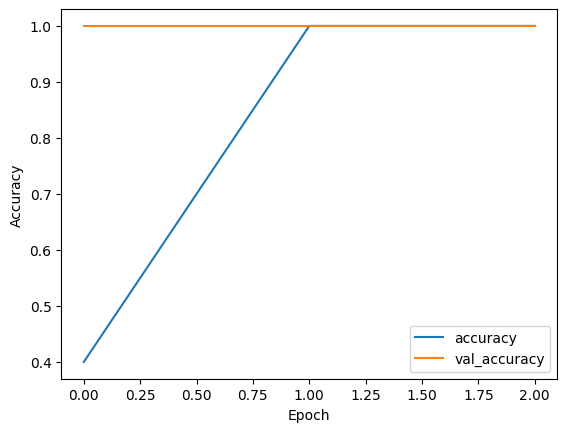

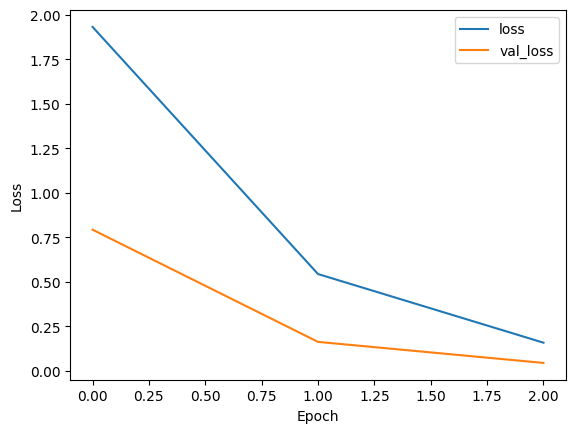

In [9]:

# video_model.model_summary()

# Plot accuracy and loss
video_model.plot_accuracy()
video_model.plot_loss()

In [10]:
video_model.model_summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 60, 224, 224, 3)   0         
                                                                 
 time_distributed (TimeDist  (None, 60, 7, 7, 1280)    4049571   
 ributed)                                                        
                                                                 
 dense (Dense)               (None, 60, 7, 7, 10)      12810     
                                                                 
 global_average_pooling3d (  (None, 10)                0         
 GlobalAveragePooling3D)                                         
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [13]:
# Predict test values

test_ds = tf.data.Dataset.from_generator(
    CustomFrameGenerator(X_test, Y_test, NUM_FRAMES),
    output_signature=output_signature
)
test_ds = preprocess_dataset(test_ds, BATCH_SIZE)

# Predict labels for the test dataset
predictions = video_model.predict(test_ds)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)




2/2 [==============================] - 49s 16s/step


In [29]:
encoded_Y_test = [0 if label == 'Violence' else 1 for label in Y_test]

# Calculate accuracy
accuracy = np.mean(encoded_Y_test == predicted_labels)
print("Test Accuracy:", accuracy*100)

Test Accuracy: 100.0


In [30]:
# Define the path to save the model
model_save_path = 'content/model'

# Save the trained model
video_model.model.save(model_save_path)

print("Model saved successfully at:", model_save_path)

Model saved successfully at: content/model
